In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pydicom
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm
import cv2
import glob
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import torchvision.transforms as transforms
import torchvision.utils as vutils


In [2]:

# Laad de CSV-bestanden
data_dir = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification'
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
label_coords_df = pd.read_csv(os.path.join(data_dir, 'train_label_coordinates.csv'))
series_desc_df = pd.read_csv(os.path.join(data_dir, 'train_series_descriptions.csv'))

# Combineer de gegevens op basis van study_id en series_id
merged_df = label_coords_df.merge(series_desc_df, on=['study_id', 'series_id'])
merged_df = merged_df.merge(train_df, on='study_id')

# Voeg een kolom toe voor de image path
merged_df['image_path'] = merged_df.apply(lambda row: os.path.join(data_dir, 'train_images', str(row['study_id']), str(row['series_id']), f"{row['instance_number']}.dcm"), axis=1)

# Selecteer relevante kolommen voor classificatie (pas deze aan naar je eigen taak)
conditions = [
    'spinal_canal_stenosis_l1_l2', 'spinal_canal_stenosis_l2_l3', 'spinal_canal_stenosis_l3_l4',
    'spinal_canal_stenosis_l4_l5', 'spinal_canal_stenosis_l5_s1',
    'left_neural_foraminal_narrowing_l1_l2', 'left_neural_foraminal_narrowing_l2_l3',
    'left_neural_foraminal_narrowing_l3_l4', 'left_neural_foraminal_narrowing_l4_l5'
]

# Houd alleen de rijen waar alle condities beschikbaar zijn
merged_df = merged_df.dropna(subset=conditions)

In [3]:
# List out all of the Studies we have on patients.
part_1 = os.listdir('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images')
part_1 = list(filter(lambda x: x.find('.DS') == -1, part_1))


df_meta_f = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')

p1 = [(x, f"/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/{x}") for x in part_1]
meta_obj = { p[0]: { 'folder_path': p[1], 
                    'SeriesInstanceUIDs': [] 
                   } 
            for p in p1 }
for m in meta_obj:
    meta_obj[m]['SeriesInstanceUIDs'] = list(
        filter(lambda x: x.find('.DS') == -1, 
               os.listdir(meta_obj[m]['folder_path'])
              )
    )


# grabs the correspoding series descriptions
for k in tqdm(meta_obj):
    for s in meta_obj[k]['SeriesInstanceUIDs']:
        if 'SeriesDescriptions' not in meta_obj[k]:
            meta_obj[k]['SeriesDescriptions'] = []
        try:
            meta_obj[k]['SeriesDescriptions'].append(
                df_meta_f[(df_meta_f['study_id'] == int(k)) & 
                (df_meta_f['series_id'] == int(s))]['series_description'].iloc[0])
        except:
            print("Failed on", s, k)

meta_obj[list(meta_obj.keys())[1]]
patient = train_df.iloc[1]
ptobj = meta_obj[str(patient['study_id'])]

100%|██████████| 1975/1975 [00:03<00:00, 603.01it/s]


In [4]:
meta_obj[list(meta_obj.keys())[1]]

{'folder_path': '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1972129014',
 'SeriesInstanceUIDs': ['2898623075', '3324327485', '3203550406'],
 'SeriesDescriptions': ['Sagittal T2/STIR', 'Axial T2', 'Sagittal T1']}

In [5]:
patient = train_df.iloc[1]

In [6]:
df_coor = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')

In [7]:
ptobj = meta_obj[str(patient['study_id'])]

In [8]:
im_list_dcm = {}
for idx, i in enumerate(ptobj['SeriesInstanceUIDs']):
    im_list_dcm[i] = {'images': [], 'description': ptobj['SeriesDescriptions'][idx]}
    images = glob.glob(f"{ptobj['folder_path']}/{ptobj['SeriesInstanceUIDs'][idx]}/*.dcm")
    for j in sorted(images, key=lambda x: int(x.split('/')[-1].replace('.dcm', ''))):
        im_list_dcm[i]['images'].append({
            'SOPInstanceUID': j.split('/')[-1].replace('.dcm', ''), 
            'dicom': pydicom.dcmread(j) })

In [9]:
def display_coor_on_img(c, i, title):
    center_coordinates = (int(c['x']), int(c['y']))
    radius = 10
    color = (255, 0, 0)  # Red color in BGR
    thickness = 2
    IMG = i['dicom'].pixel_array
    IMG_normalized = cv2.normalize(IMG, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    IMG_with_circle = cv2.circle(IMG_normalized.copy(), center_coordinates, radius, color, thickness)
    
    # Convert the image from BGR to RGB for correct color display in matplotlib
    IMG_with_circle = cv2.cvtColor(IMG_with_circle, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.imshow(IMG_with_circle)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.title(title)
    plt.show()

In [10]:
coor_entries = df_coor[df_coor['study_id'] == int(patient['study_id'])]

Only showing severe cases for this patient


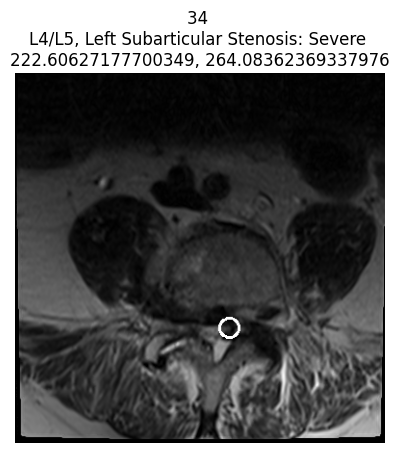

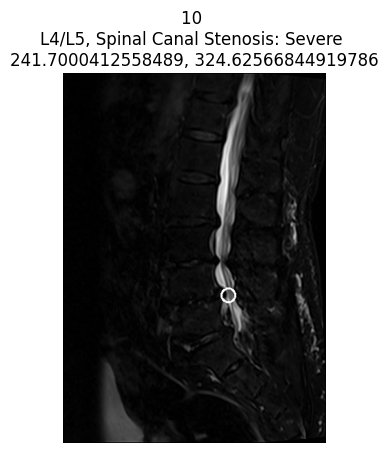

In [11]:
print("Only showing severe cases for this patient")
for idc, c in coor_entries.iterrows():
    for i in im_list_dcm[str(c['series_id'])]['images']:
        if int(i['SOPInstanceUID']) == int(c['instance_number']):
            try:
                patient_severity = patient[
                    f"{c['condition'].lower().replace(' ', '_')}_{c['level'].lower().replace('/', '_')}"
                ]
            except Exception as e:
                patient_severity = "unknown severity"
            title = f"{i['SOPInstanceUID']} \n{c['level']}, {c['condition']}: {patient_severity} \n{c['x']}, {c['y']}"
            if patient_severity == 'Severe':
                display_coor_on_img(c, i, title)

In [12]:
!pip install torchio open3d timm_3d spacecutter skorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.4/174.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 4.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.8/626.8 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 46.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 71.0 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.8
    Uninstalling widgetsnbextension-3.6.8:
      Successfully uninstalled widgetsnbextension-3.6.8
  Attempting uninstall: jupyterlab-widgets
    Found existing

In [13]:
import os
import gc
import sys
from PIL import Image
import cv2
import math, random
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import traceback
from collections import OrderedDict

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

import timm
from transformers import get_cosine_schedule_with_warmup

import albumentations as A

from sklearn.model_selection import KFold

import re

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [14]:
def imread_and_imwirte(src_path, dst_path):
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() +1e-6) * 255
    img = cv2.resize(image, (512, 512),interpolation=cv2.INTER_CUBIC)
    assert img.shape==(512,512)
    cv2.imwrite(dst_path, img)

In [15]:
rd = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification'
df = pd.read_csv(f'{rd}/train_series_descriptions.csv')
st_ids = df['study_id'].unique()
dfc = pd.read_csv(f'{rd}/train_label_coordinates.csv')
desc = list(df['series_description'].unique())

In [16]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [17]:
for idx, si in enumerate(tqdm(st_ids, total=len(st_ids))):
    pdf = df[df['study_id']==si]
    for ds in desc:
        ds_ = ds.replace('/', '_')
        pdf_ = pdf[pdf['series_description']==ds]
        os.makedirs(f'cvt_png/{si}/{ds_}', exist_ok=True)
        allimgs = []
        for i, row in pdf_.iterrows():
            pimgs = glob.glob(f'{rd}/train_images/{row["study_id"]}/{row["series_id"]}/*.dcm')
            pimgs = sorted(pimgs, key=natural_keys)
            allimgs.extend(pimgs)
            
        if len(allimgs)==0:
            print(si, ds, 'has no images')
            continue

        if ds == 'Axial T2':
            for j, impath in enumerate(allimgs):
                dst = f'cvt_png/{si}/{ds}/{j:03d}.png'
                imread_and_imwirte(impath, dst)
                
        elif ds == 'Sagittal T2/STIR':
            
            step = len(allimgs) / 10.0
            st = len(allimgs)/2.0 - 4.0*step
            end = len(allimgs)+0.0001
            for j, i in enumerate(np.arange(st, end, step)):
                dst = f'cvt_png/{si}/{ds_}/{j:03d}.png'
                ind2 = max(0, int((i-0.5001).round()))
                imread_and_imwirte(allimgs[ind2], dst)
                
            assert len(glob.glob(f'cvt_png/{si}/{ds_}/*.png'))==10
                
        elif ds == 'Sagittal T1':
            step = len(allimgs) / 10.0
            st = len(allimgs)/2.0 - 4.0*step
            end = len(allimgs)+0.0001
            for j, i in enumerate(np.arange(st, end, step)):
                dst = f'cvt_png/{si}/{ds}/{j:03d}.png'
                ind2 = max(0, int((i-0.5001).round()))
                imread_and_imwirte(allimgs[ind2], dst)
                
            assert len(glob.glob(f'cvt_png/{si}/{ds}/*.png'))==10

 57%|█████▋    | 1126/1975 [29:44<19:26,  1.37s/it] 

2492114990 Sagittal T1 has no images


 64%|██████▍   | 1272/1975 [33:22<15:46,  1.35s/it]

2780132468 Sagittal T1 has no images


 70%|██████▉   | 1378/1975 [36:11<12:37,  1.27s/it]

3008676218 Sagittal T2/STIR has no images


100%|██████████| 1975/1975 [51:26<00:00,  1.56s/it]


In [18]:
NOT_DEBUG = True # True -> run naormally, False -> debug mode, with lesser computing cost

OUTPUT_DIR = f'rsna24-results'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
N_WORKERS = os.cpu_count() 
USE_AMP = True # can change True if using T4 or newer than Ampere
SEED = 8620

IMG_SIZE = [512, 512]
IN_CHANS = 30
N_LABELS = 25
N_CLASSES = 3 * N_LABELS

AUG_PROB = 0.75

N_FOLDS = 5 if NOT_DEBUG else 2
EPOCHS = 20 if NOT_DEBUG else 2
MODEL_NAME = "tf_efficientnet_b3.ns_jft_in1k" if NOT_DEBUG else "tf_efficientnet_b0.ns_jft_in1k"

GRAD_ACC = 2
TGT_BATCH_SIZE = 32
BATCH_SIZE = TGT_BATCH_SIZE // GRAD_ACC
MAX_GRAD_NORM = None
EARLY_STOPPING_EPOCH = 3

LR = 2e-4 * TGT_BATCH_SIZE / 32
WD = 1e-2
AUG = True


In [19]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [20]:
def set_random_seed(seed: int = 8620, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = deterministic  # type: ignore


In [21]:
df = pd.read_csv(f'{rd}/train.csv')
df.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [22]:
df = df.fillna(-100)

In [23]:
label2id = {'Normal/Mild': 0, 'Moderate':1, 'Severe':2}
df = df.replace(label2id)
df.head()

/tmp/ipykernel_36/1901592955.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(label2id)


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,4646740,0,0,1,2,0,0,0,0,1,...,0,0,0,2,0,0,1,1,1,0
2,7143189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8785691,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,10728036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [24]:
CONDITIONS = [
    'Spinal Canal Stenosis', 
    'Left Neural Foraminal Narrowing', 
    'Right Neural Foraminal Narrowing',
    'Left Subarticular Stenosis',
    'Right Subarticular Stenosis'
]

LEVELS = [
    'L1/L2',
    'L2/L3',
    'L3/L4',
    'L4/L5',
    'L5/S1',
]

In [25]:
class RSNA24Dataset(Dataset):
    def __init__(self, df, phase='train', transform=None):
        self.df = df
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = np.zeros((512, 512, IN_CHANS), dtype=np.uint8)
        t = self.df.iloc[idx]
        st_id = int(t['study_id'])
        label = t[1:].values.astype(np.int64)
        
        # Sagittal T1
        for i in range(0, 10, 1):
            try:
                p = f'./cvt_png/{st_id}/Sagittal T1/{i:03d}.png'
                img = Image.open(p).convert('L')
                img = np.array(img)
                x[..., i] = img.astype(np.uint8)
            except Exception as e:
                print(f'Failed to load on {st_id}, Sagittal T1, error: {e}')
                traceback.print_exc()
                pass
            
        # Sagittal T2/STIR
        for i in range(0, 10, 1):
            try:
                p = f'./cvt_png/{st_id}/Sagittal T2_STIR/{i:03d}.png'
                img = Image.open(p).convert('L')
                img = np.array(img)
                x[..., i+10] = img.astype(np.uint8)
            except Exception as e:
                print(f'Failed to load on {st_id}, Sagittal T1, error: {e}')
                traceback.print_exc()
                pass
            
        # Axial T2
        axt2 = glob.glob(f'./cvt_png/{st_id}/Axial T2/*.png')
        axt2 = sorted(axt2)
    
        step = len(axt2) / 10.0
        st = len(axt2)/2.0 - 4.0*step
        end = len(axt2)+0.0001
                
        for i, j in enumerate(np.arange(st, end, step)):
            try:
                p = axt2[max(0, int((j-0.5001).round()))]
                img = Image.open(p).convert('L')
                img = np.array(img)
                x[..., i+20] = img.astype(np.uint8)
            except Exception as e:
                print(f'Failed to load on {st_id}, Sagittal T1, error: {e}')
                traceback.print_exc()
                pass
            
        assert np.sum(x)>0
            
        if self.transform is not None:
            x = self.transform(image=x)['image']

        x = x.transpose(2, 0, 1)
                
        return x, label

In [26]:
transforms_train = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=AUG_PROB),
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
        A.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=AUG_PROB),

    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=AUG_PROB),

    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=AUG_PROB),
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.CoarseDropout(max_holes=16, max_height=64, max_width=64, min_holes=1, min_height=8, min_width=8, p=AUG_PROB),    
    A.Normalize(mean=0.5, std=0.5)
])

transforms_val = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=0.5, std=0.5)
])

if not NOT_DEBUG or not AUG:
    transforms_train = transforms_val

/opt/conda/lib/python3.10/site-packages/pydantic/main.py:193: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  self.__pydantic_validator__.validate_python(data, self_instance=self)


In [27]:
tmp_ds = RSNA24Dataset(df, phase='train', transform=transforms_train)
tmp_dl = DataLoader(
            tmp_ds,
            batch_size=1,
            shuffle=False,
            pin_memory=True,
            drop_last=False,
            num_workers=0
            )


x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(1.) tensor(-0.6748) tensor(0.3687)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0]]) torch.Size([1, 25])


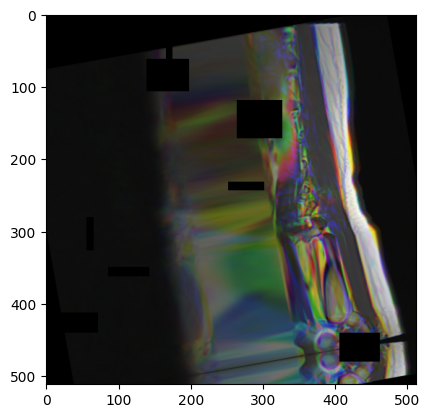

y stat: (512, 512, 3) 0.0 0.98823535 0.16859795 0.17596304

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(1.) tensor(-0.6753) tensor(0.3205)
tensor([[0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1,
         0]]) torch.Size([1, 25])


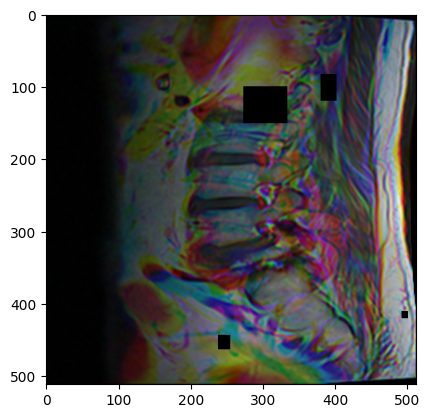

y stat: (512, 512, 3) 0.0 1.0 0.21947904 0.17903648

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(0.8745) tensor(-0.8397) tensor(0.2346)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]) torch.Size([1, 25])


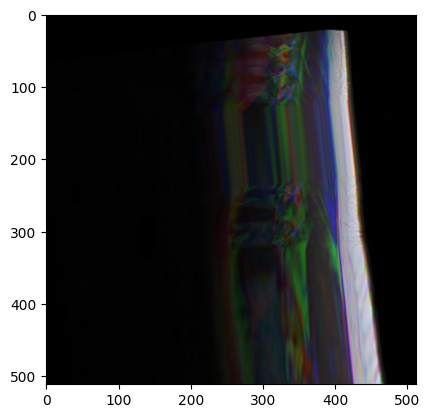

y stat: (512, 512, 3) 0.0 0.9372549 0.089039944 0.16533001

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(1.) tensor(-0.4041) tensor(0.3859)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]) torch.Size([1, 25])


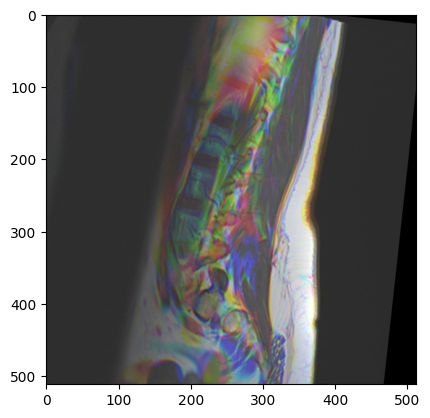

y stat: (512, 512, 3) 0.0 1.0 0.29040045 0.18363921

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(0.4588) tensor(-0.7661) tensor(0.2747)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0]]) torch.Size([1, 25])


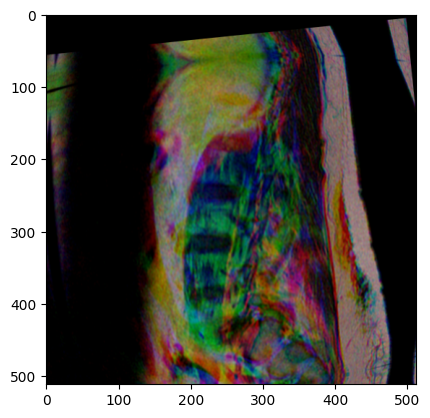

y stat: (512, 512, 3) 0.0 0.7294118 0.15833408 0.18383983



In [28]:

for i, (x, t) in enumerate(tmp_dl):
    if i==5:break
    print('x stat:', x.shape, x.min(), x.max(),x.mean(), x.std())
    print(t, t.shape)
    y = x.numpy().transpose(0,2,3,1)[0,...,:3]
    y = (y + 1) / 2
    plt.imshow(y)
    plt.show()
    print('y stat:', y.shape, y.min(), y.max(),y.mean(), y.std())
    print()
plt.close()
del tmp_ds, tmp_dl

In [29]:
class RSNA24Model(nn.Module):
    def __init__(self, model_name, in_c=30, n_classes=75, pretrained=True, features_only=False):
        super().__init__()
        self.model = timm.create_model(
                                    model_name,
                                    pretrained=pretrained, 
                                    features_only=features_only,
                                    in_chans=in_c,
                                    num_classes=n_classes,
                                    global_pool='avg'
                                    )
    
    def forward(self, x):
        y = self.model(x)
        return y

In [30]:
m = RSNA24Model(MODEL_NAME, in_c=IN_CHANS, n_classes=N_CLASSES, pretrained=False)
i = torch.randn(2, IN_CHANS, 512, 512)
out = m(i)
for o in out:
    print(o.shape, o.min(), o.max())

torch.Size([75]) tensor(-1.1852, grad_fn=<MinBackward1>) tensor(1.2867, grad_fn=<MaxBackward1>)
torch.Size([75]) tensor(-1.1135, grad_fn=<MinBackward1>) tensor(1.1036, grad_fn=<MaxBackward1>)


In [31]:
del m, i, out

In [ ]:
from collections import OrderedDict
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import AdamW
from transformers import get_cosine_schedule_with_warmup

# Autocast and GradScaler initialization
autocast = torch.amp.autocast(device, enabled=USE_AMP, dtype=torch.half)
scaler = torch.amp.GradScaler(enabled=USE_AMP, init_scale=4096)

# Stratified K-Fold
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
    print('#'*30)
    print(f'Start fold {fold}')
    print('#'*30)
    print(len(trn_idx), len(val_idx))

    # Data preparation
    df_train = df.iloc[trn_idx]
    df_valid = df.iloc[val_idx]

    train_ds = RSNA24Dataset(df_train, phase='train', transform=transforms_train)
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, drop_last=True, num_workers=N_WORKERS)

    valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
    valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE * 2, shuffle=False, pin_memory=True, drop_last=False, num_workers=N_WORKERS)

    # Model, optimizer, scheduler
    model = RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=True)
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WD)

    warmup_steps = EPOCHS / 10 * len(train_dl) // GRAD_ACC
    num_total_steps = EPOCHS * len(train_dl) // GRAD_ACC
    num_cycles = 0.475
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_total_steps, num_cycles=num_cycles)

    # Loss function with weights
    weights = torch.tensor([1.0, 2.0, 4.0])
    criterion = nn.CrossEntropyLoss(weight=weights.to(device))

    best_loss = 1.2
    best_wll = 1.2
    es_step = 0

    def compute_loss(y, t, criterion):
        """Helper function to compute loss over columns."""
        loss = 0
        for col in range(N_LABELS):
            pred = y[:, col * 3: col * 3 + 3]
            gt = t[:, col]
            loss += criterion(pred, gt) / N_LABELS
        return loss

    # Training and validation loop
    for epoch in range(1, EPOCHS + 1):
        print(f'Start epoch {epoch}')

        # Training phase
        model.train()
        total_loss = 0
        optimizer.zero_grad(set_to_none=True)

        with tqdm(train_dl, leave=True) as pbar:
            for idx, (x, t) in enumerate(pbar):
                x, t = x.to(device), t.to(device)

                with autocast:
                    y = model(x)
                    loss = compute_loss(y, t, criterion)

                    total_loss += loss.item()
                    if GRAD_ACC > 1:
                        loss /= GRAD_ACC

                # Handle NaN loss
                if not math.isfinite(loss):
                    print(f"Loss is {loss}, stopping training")
                    sys.exit(1)

                pbar.set_postfix(OrderedDict(loss=f'{loss.item() * GRAD_ACC:.6f}', lr=f'{optimizer.param_groups[0]["lr"]:.3e}'))
                scaler.scale(loss).backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM or 1e9)

                if (idx + 1) % GRAD_ACC == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad(set_to_none=True)

                    if scheduler is not None:
                        scheduler.step()

        train_loss = total_loss / len(train_dl)
        print(f'train_loss: {train_loss:.6f}')

        # Validation phase
        model.eval()
        total_loss = 0
        y_preds = []
        labels = []

        with tqdm(valid_dl, leave=True) as pbar:
            with torch.no_grad():
                for idx, (x, t) in enumerate(pbar):
                    x, t = x.to(device), t.to(device)

                    with autocast:
                        y = model(x)
                        loss = compute_loss(y, t, criterion)
                        total_loss += loss.item()

                        # Collect predictions and labels for evaluation
                        for col in range(N_LABELS):
                            pred = y[:, col * 3:col * 3 + 3]
                            y_preds.append(pred.float().cpu())
                            labels.append(t[:, col].cpu())

        val_loss = total_loss / len(valid_dl)
        y_preds = torch.cat(y_preds, dim=0)
        labels = torch.cat(labels)
        val_wll = nn.CrossEntropyLoss()(y_preds, labels)

        print(f'val_loss: {val_loss:.6f}, val_wll: {val_wll:.6f}')

        # Early stopping and saving the best model
        if val_loss < best_loss or val_wll < best_wll:
            es_step = 0

            if val_loss < best_loss:
                print(f'Epoch: {epoch}, best loss updated from {best_loss:.6f} to {val_loss:.6f}')
                best_loss = val_loss

            if val_wll < best_wll:
                print(f'Epoch: {epoch}, best wll_metric updated from {best_wll:.6f} to {val_wll:.6f}')
                best_wll = val_wll
                torch.save(model.state_dict(), f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt')

        else:
            es_step += 1
            if es_step >= EARLY_STOPPING_EPOCH:
                print('Early stopping')
                break


##############################
Start fold 0
##############################
1580 395


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Start epoch 1


  0%|          | 0/98 [00:00<?, ?it/s]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 70%|███████   | 69/98 [03:42<01:20,  2.78s/it, loss=0.855375, lr=6.939e-05]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [05:10<00:00,  3.17s/it, loss=0.857542, lr=9.796e-05]


train_loss: 1.003947


100%|██████████| 13/13 [01:22<00:00,  6.35s/it]


val_loss: 0.832637, val_wll: 0.730040
Epoch: 1, best loss updated from 1.200000 to 0.832637
Epoch: 1, best wll_metric updated from 1.200000 to 0.730040
Start epoch 2


  0%|          | 0/98 [00:00<?, ?it/s]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


 45%|████▍     | 44/98 [02:11<01:44,  1.94s/it, loss=0.694712, lr=1.429e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 92%|█████████▏| 90/98 [04:29<00:18,  2.36s/it, loss=0.804331, lr=1.898e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:49<00:00,  2.95s/it, loss=0.773089, lr=1.980e-04]


train_loss: 0.772472


100%|██████████| 13/13 [01:54<00:00,  8.83s/it]


val_loss: 0.746850, val_wll: 0.586269
Epoch: 2, best loss updated from 0.832637 to 0.746850
Epoch: 2, best wll_metric updated from 0.730040 to 0.586269
Start epoch 3


  4%|▍         | 4/98 [00:14<03:27,  2.21s/it, loss=0.719201, lr=2.000e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 12%|█▏        | 12/98 [01:05<04:06,  2.87s/it, loss=0.781398, lr=2.000e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


 13%|█▎        | 13/98 [01:05<10:18,  7.27s/it, loss=0.781398, lr=2.000e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


 52%|█████▏    | 51/98 [03:02<01:55,  2.45s/it, loss=0.860712, lr=1.996e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 98/98 [05:32<00:00,  3.39s/it, loss=0.611109, lr=1.987e-04]


train_loss: 0.727225


100%|██████████| 13/13 [01:36<00:00,  7.41s/it]


val_loss: 0.705165, val_wll: 0.561571
Epoch: 3, best loss updated from 0.746850 to 0.705165
Epoch: 3, best wll_metric updated from 0.586269 to 0.561571
Start epoch 4


 24%|██▍       | 24/98 [01:13<02:19,  1.89s/it, loss=0.587864, lr=1.979e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


 84%|████████▎ | 82/98 [05:36<01:00,  3.77s/it, loss=0.648901, lr=1.955e-04]

failed to load on 2780132468, Sagittal T1

 84%|████████▎ | 82/98 [05:36<01:00,  3.77s/it, loss=0.695167, lr=1.954e-04]


failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1

 85%|████████▍ | 83/98 [05:36<00:40,  2.72s/it, loss=0.695167, lr=1.954e-04]


failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 98%|█████████▊| 96/98 [06:11<00:03,  1.76s/it, loss=0.609478, lr=1.948e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [06:19<00:00,  3.87s/it, loss=0.595785, lr=1.947e-04]


train_loss: 0.695077


100%|██████████| 13/13 [01:51<00:00,  8.55s/it]


val_loss: 0.676448, val_wll: 0.566431
Epoch: 4, best loss updated from 0.705165 to 0.676448
Start epoch 5


 12%|█▏        | 12/98 [00:37<02:39,  1.86s/it, loss=0.626472, lr=1.940e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


 69%|██████▉   | 68/98 [04:14<02:09,  4.30s/it, loss=0.656569, lr=1.903e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


 80%|███████▉  | 78/98 [04:47<01:00,  3.04s/it, loss=0.706763, lr=1.896e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


100%|██████████| 98/98 [05:54<00:00,  3.62s/it, loss=0.658172, lr=1.880e-04]


train_loss: 0.664409


100%|██████████| 13/13 [01:47<00:00,  8.26s/it]


val_loss: 0.673440, val_wll: 0.576166
Epoch: 5, best loss updated from 0.676448 to 0.673440
Start epoch 6


  9%|▉         | 9/98 [00:33<05:37,  3.79s/it, loss=0.699501, lr=1.872e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 33%|███▎      | 32/98 [01:39<02:30,  2.29s/it, loss=0.596835, lr=1.853e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


 36%|███▌      | 35/98 [01:56<03:43,  3.55s/it, loss=0.617025, lr=1.850e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1

 36%|███▌      | 35/98 [01:56<03:43,  3.55s/it, loss=0.540393, lr=1.850e-04]


failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [05:45<00:00,  3.53s/it, loss=0.548269, lr=1.790e-04]


train_loss: 0.639816


100%|██████████| 13/13 [02:06<00:00,  9.72s/it]


val_loss: 0.674113, val_wll: 0.585824
Start epoch 7


 49%|████▉     | 48/98 [02:42<02:04,  2.49s/it, loss=0.531602, lr=1.738e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


 57%|█████▋    | 56/98 [03:23<01:46,  2.53s/it, loss=0.631022, lr=1.729e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 61%|██████    | 60/98 [03:37<01:24,  2.23s/it, loss=0.617297, lr=1.724e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 98/98 [05:57<00:00,  3.65s/it, loss=0.651442, lr=1.678e-04]


train_loss: 0.620929


100%|██████████| 13/13 [01:27<00:00,  6.73s/it]


val_loss: 0.662669, val_wll: 0.558639
Epoch: 7, best loss updated from 0.673440 to 0.662669
Epoch: 7, best wll_metric updated from 0.561571 to 0.558639
Start epoch 8


 11%|█         | 11/98 [00:34<03:20,  2.31s/it, loss=0.671759, lr=1.663e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1

 11%|█         | 11/98 [00:34<03:20,  2.31s/it, loss=0.584424, lr=1.663e-04]


failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


 28%|██▊       | 27/98 [01:25<04:21,  3.68s/it, loss=0.589065, lr=1.643e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


 29%|██▊       | 28/98 [01:26<03:16,  2.80s/it, loss=0.589065, lr=1.643e-04]

failed to load on 3008676218, Sagittal T2/STIR


 79%|███████▊  | 77/98 [03:58<00:57,  2.75s/it, loss=0.539236, lr=1.575e-04]

failed to load on 2780132468, Sagittal T1


 79%|███████▊  | 77/98 [04:03<00:57,  2.75s/it, loss=0.720443, lr=1.575e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


100%|██████████| 98/98 [05:13<00:00,  3.20s/it, loss=0.551906, lr=1.547e-04]


train_loss: 0.599131


100%|██████████| 13/13 [01:41<00:00,  7.81s/it]


val_loss: 0.665420, val_wll: 0.543480
Epoch: 8, best wll_metric updated from 0.558639 to 0.543480
Start epoch 9


  0%|          | 0/98 [00:00<?, ?it/s]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


  6%|▌         | 6/98 [00:23<05:00,  3.26s/it, loss=0.544409, lr=1.539e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


  6%|▌         | 6/98 [00:23<05:00,  3.26s/it, loss=0.559667, lr=1.536e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


  7%|▋         | 7/98 [00:23<03:27,  2.28s/it, loss=0.559667, lr=1.536e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


 82%|████████▏ | 80/98 [03:46<00:35,  1.96s/it, loss=0.682835, lr=1.430e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


100%|██████████| 98/98 [04:37<00:00,  2.83s/it, loss=0.515099, lr=1.402e-04]


train_loss: 0.588230


100%|██████████| 13/13 [01:28<00:00,  6.82s/it]


val_loss: 0.660648, val_wll: 0.557968
Epoch: 9, best loss updated from 0.662669 to 0.660648
Start epoch 10


  8%|▊         | 8/98 [00:24<02:42,  1.81s/it, loss=0.467322, lr=1.389e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 33%|███▎      | 32/98 [01:32<02:01,  1.84s/it, loss=0.573158, lr=1.352e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


 62%|██████▏   | 61/98 [02:53<02:19,  3.76s/it, loss=0.543880, lr=1.304e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:34<00:00,  2.80s/it, loss=0.489122, lr=1.245e-04]


train_loss: 0.569201


100%|██████████| 13/13 [01:34<00:00,  7.25s/it]


val_loss: 0.661900, val_wll: 0.552813
Start epoch 11


 24%|██▍       | 24/98 [01:10<02:13,  1.81s/it, loss=0.548588, lr=1.206e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 63%|██████▎   | 62/98 [02:55<01:41,  2.81s/it, loss=0.532206, lr=1.142e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


 65%|██████▌   | 64/98 [03:01<01:30,  2.68s/it, loss=0.509163, lr=1.139e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:32<00:00,  2.78s/it, loss=0.510630, lr=1.082e-04]


train_loss: 0.549426


100%|██████████| 13/13 [01:11<00:00,  5.50s/it]


val_loss: 0.677584, val_wll: 0.549387
Start epoch 12


  3%|▎         | 3/98 [00:11<04:39,  2.94s/it, loss=0.509255, lr=1.075e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR

  3%|▎         | 3/98 [00:12<04:39,  2.94s/it, loss=0.558856, lr=1.075e-04]


failed to load on 3008676218, Sagittal T2/STIR


  4%|▍         | 4/98 [00:12<03:16,  2.09s/it, loss=0.558856, lr=1.075e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


 61%|██████    | 60/98 [02:42<01:16,  2.02s/it, loss=0.459468, lr=9.804e-05]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1failed to load on 2780132468, Sagittal T1

failed to load on 2780132468, Sagittal T1


100%|██████████| 98/98 [04:28<00:00,  2.74s/it, loss=0.542593, lr=9.162e-05]


train_loss: 0.532749


100%|██████████| 13/13 [01:00<00:00,  4.68s/it]


val_loss: 0.683273, val_wll: 0.562192
Early stopping
##############################
Start fold 1
##############################
1580 395
Start epoch 1


 73%|███████▎  | 72/98 [03:18<00:47,  1.84s/it, loss=0.883360, lr=7.143e-05]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:25<00:00,  2.71s/it, loss=0.742283, lr=9.796e-05]


train_loss: 1.012313


 31%|███       | 4/13 [00:58<01:12,  8.05s/it]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 62%|██████▏   | 8/13 [01:14<00:17,  3.55s/it]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 13/13 [01:27<00:00,  6.70s/it]


val_loss: 0.822597, val_wll: 0.695355
Epoch: 1, best loss updated from 1.200000 to 0.822597
Epoch: 1, best wll_metric updated from 1.200000 to 0.695355
Start epoch 2


 45%|████▍     | 44/98 [01:59<01:52,  2.08s/it, loss=0.691987, lr=1.429e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:28<00:00,  2.74s/it, loss=0.819984, lr=1.980e-04]


train_loss: 0.777214


 31%|███       | 4/13 [00:55<01:09,  7.71s/it]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 62%|██████▏   | 8/13 [01:09<00:15,  3.10s/it]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 13/13 [01:21<00:00,  6.27s/it]


val_loss: 0.758342, val_wll: 0.632395
Epoch: 2, best loss updated from 0.822597 to 0.758342
Epoch: 2, best wll_metric updated from 0.695355 to 0.632395
Start epoch 3


100%|██████████| 98/98 [04:28<00:00,  2.74s/it, loss=0.740853, lr=1.987e-04]


train_loss: 0.729914


 31%|███       | 4/13 [00:59<01:15,  8.41s/it]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 62%|██████▏   | 8/13 [01:19<00:20,  4.12s/it]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 13/13 [01:29<00:00,  6.91s/it]


val_loss: 0.720576, val_wll: 0.618604
Epoch: 3, best loss updated from 0.758342 to 0.720576
Epoch: 3, best wll_metric updated from 0.632395 to 0.618604
Start epoch 4


  0%|          | 0/98 [00:00<?, ?it/s]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:29<00:00,  2.75s/it, loss=0.670741, lr=1.947e-04]


train_loss: 0.690709


 31%|███       | 4/13 [01:04<01:20,  8.93s/it]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 62%|██████▏   | 8/13 [01:19<00:17,  3.44s/it]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 13/13 [01:32<00:00,  7.09s/it]


val_loss: 0.701484, val_wll: 0.585144
Epoch: 4, best loss updated from 0.720576 to 0.701484
Epoch: 4, best wll_metric updated from 0.618604 to 0.585144
Start epoch 5


 29%|██▊       | 28/98 [01:16<02:13,  1.91s/it, loss=0.818237, lr=1.930e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:30<00:00,  2.76s/it, loss=0.652324, lr=1.880e-04]


train_loss: 0.669365


 31%|███       | 4/13 [00:53<01:07,  7.51s/it]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 62%|██████▏   | 8/13 [01:06<00:15,  3.13s/it]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 13/13 [01:18<00:00,  6.05s/it]


val_loss: 0.692566, val_wll: 0.620293
Epoch: 5, best loss updated from 0.701484 to 0.692566
Start epoch 6


 60%|██████    | 59/98 [02:41<01:33,  2.40s/it, loss=0.689782, lr=1.828e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:23<00:00,  2.69s/it, loss=0.710471, lr=1.790e-04]


train_loss: 0.643713


 31%|███       | 4/13 [00:58<01:13,  8.12s/it]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 62%|██████▏   | 8/13 [01:11<00:15,  3.16s/it]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 13/13 [01:22<00:00,  6.36s/it]


val_loss: 0.684768, val_wll: 0.567676
Epoch: 6, best loss updated from 0.692566 to 0.684768
Epoch: 6, best wll_metric updated from 0.585144 to 0.567676
Start epoch 7


  4%|▍         | 4/98 [00:13<03:20,  2.13s/it, loss=0.656437, lr=1.786e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:19<00:00,  2.65s/it, loss=0.632753, lr=1.678e-04]


train_loss: 0.618890


 31%|███       | 4/13 [00:58<01:15,  8.40s/it]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 62%|██████▏   | 8/13 [01:12<00:17,  3.41s/it]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 13/13 [01:25<00:00,  6.54s/it]


val_loss: 0.686086, val_wll: 0.551663
Epoch: 7, best wll_metric updated from 0.567676 to 0.551663
Start epoch 8


  0%|          | 0/98 [00:00<?, ?it/s]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:18<00:00,  2.63s/it, loss=0.725394, lr=1.547e-04]


train_loss: 0.604431


 31%|███       | 4/13 [00:51<01:03,  7.09s/it]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 62%|██████▏   | 8/13 [01:04<00:14,  3.00s/it]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 13/13 [01:15<00:00,  5.80s/it]


val_loss: 0.681492, val_wll: 0.542947
Epoch: 8, best loss updated from 0.684768 to 0.681492
Epoch: 8, best wll_metric updated from 0.551663 to 0.542947
Start epoch 9


  4%|▍         | 4/98 [00:12<03:08,  2.01s/it, loss=0.626600, lr=1.542e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1

failed to load on 2492114990, Sagittal T1failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:23<00:00,  2.69s/it, loss=0.527928, lr=1.402e-04]


train_loss: 0.597648


 31%|███       | 4/13 [00:48<01:02,  6.96s/it]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 62%|██████▏   | 8/13 [01:03<00:17,  3.59s/it]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 13/13 [01:15<00:00,  5.83s/it]


val_loss: 0.669917, val_wll: 0.543859
Epoch: 9, best loss updated from 0.681492 to 0.669917
Start epoch 10


 12%|█▏        | 12/98 [00:37<02:50,  1.98s/it, loss=0.592070, lr=1.383e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:35<00:00,  2.81s/it, loss=0.714906, lr=1.245e-04]


train_loss: 0.577684


 31%|███       | 4/13 [00:43<00:53,  5.98s/it]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 62%|██████▏   | 8/13 [01:01<00:16,  3.32s/it]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 13/13 [01:13<00:00,  5.66s/it]


val_loss: 0.674097, val_wll: 0.574862
Start epoch 11


 74%|███████▍  | 73/98 [03:15<00:52,  2.09s/it, loss=0.445664, lr=1.122e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:20<00:00,  2.66s/it, loss=0.646483, lr=1.082e-04]


train_loss: 0.558600


 31%|███       | 4/13 [00:45<00:56,  6.32s/it]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 62%|██████▏   | 8/13 [01:03<00:16,  3.30s/it]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 13/13 [01:14<00:00,  5.71s/it]


val_loss: 0.687601, val_wll: 0.544931
Start epoch 12


 69%|██████▉   | 68/98 [03:02<00:58,  1.95s/it, loss=0.606349, lr=9.669e-05]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:20<00:00,  2.66s/it, loss=0.422057, lr=9.162e-05]


train_loss: 0.540435


 31%|███       | 4/13 [00:40<00:52,  5.79s/it]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 62%|██████▏   | 8/13 [00:59<00:16,  3.32s/it]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 13/13 [01:11<00:00,  5.54s/it]


val_loss: 0.686147, val_wll: 0.561478
Early stopping
##############################
Start fold 2
##############################
1580 395
Start epoch 1


 20%|██        | 20/98 [00:54<02:10,  1.67s/it, loss=1.120441, lr=1.837e-05]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 90%|████████▉ | 88/98 [03:54<00:18,  1.82s/it, loss=0.774061, lr=8.776e-05]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 98/98 [04:22<00:00,  2.68s/it, loss=0.813831, lr=9.796e-05]


train_loss: 0.989254


  0%|          | 0/13 [00:00<?, ?it/s]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 13/13 [01:15<00:00,  5.83s/it]


val_loss: 0.811079, val_wll: 0.699674
Epoch: 1, best loss updated from 1.200000 to 0.811079
Epoch: 1, best wll_metric updated from 1.200000 to 0.699674
Start epoch 2


 24%|██▍       | 24/98 [01:06<02:10,  1.77s/it, loss=0.795487, lr=1.224e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 82%|████████▏ | 80/98 [03:38<00:34,  1.89s/it, loss=0.640967, lr=1.796e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 98/98 [04:25<00:00,  2.71s/it, loss=0.967080, lr=1.980e-04]


train_loss: 0.780265


  0%|          | 0/13 [00:00<?, ?it/s]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 13/13 [01:19<00:00,  6.13s/it]


val_loss: 0.730166, val_wll: 0.616567
Epoch: 2, best loss updated from 0.811079 to 0.730166
Epoch: 2, best wll_metric updated from 0.699674 to 0.616567
Start epoch 3


 54%|█████▍    | 53/98 [02:32<02:37,  3.50s/it, loss=0.682553, lr=1.996e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR

 55%|█████▌    | 54/98 [02:32<02:22,  3.23s/it, loss=0.682553, lr=1.996e-04]


failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


 87%|████████▋ | 85/98 [03:56<00:32,  2.47s/it, loss=0.736161, lr=1.990e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


100%|██████████| 98/98 [04:29<00:00,  2.75s/it, loss=0.682880, lr=1.987e-04]


train_loss: 0.743994


  0%|          | 0/13 [00:00<?, ?it/s]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 13/13 [01:21<00:00,  6.26s/it]


val_loss: 0.696977, val_wll: 0.599956
Epoch: 3, best loss updated from 0.730166 to 0.696977
Epoch: 3, best wll_metric updated from 0.616567 to 0.599956
Start epoch 4


 37%|███▋      | 36/98 [01:41<01:48,  1.75s/it, loss=0.652722, lr=1.975e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 78%|███████▊  | 76/98 [03:28<00:36,  1.66s/it, loss=0.711477, lr=1.958e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 98/98 [04:27<00:00,  2.73s/it, loss=0.640479, lr=1.947e-04]


train_loss: 0.704560


 23%|██▎       | 3/13 [00:44<01:40, 10.02s/it]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 13/13 [01:15<00:00,  5.82s/it]


val_loss: 0.679454, val_wll: 0.597341
Epoch: 4, best loss updated from 0.696977 to 0.679454
Epoch: 4, best wll_metric updated from 0.599956 to 0.597341
Start epoch 5


 32%|███▏      | 31/98 [01:27<02:15,  2.02s/it, loss=0.658508, lr=1.928e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 37%|███▋      | 36/98 [01:38<01:40,  1.63s/it, loss=0.697927, lr=1.925e-04]

In [ ]:
!zip-folder --auto-root --outfile /kaggle/working/cvt_png.zip /kaggle/working/

In [ ]:
cv = 0
y_preds = []
labels = []
weights = torch.tensor([1.0, 2.0, 4.0])
criterion2 = nn.CrossEntropyLoss(weight=weights)

for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
    print('#'*30)
    print(f'start fold{fold}')
    print('#'*30)
    df_valid = df.iloc[val_idx]
    valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
    valid_dl = DataLoader(
                valid_ds,
                batch_size=1,
                shuffle=False,
                pin_memory=True,
                drop_last=False,
                num_workers=N_WORKERS
                )

    model = RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=False)
    fname = f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt'
    model.load_state_dict(torch.load(fname))
    model.to(device)   
    
    model.eval()
    with tqdm(valid_dl, leave=True) as pbar:
        with torch.no_grad():
            for idx, (x, t) in enumerate(pbar):
                
                x = x.to(device)
                t = t.to(device)
                    
                with autocast:
                    y = model(x)
                    for col in range(N_LABELS):
                        pred = y[:,col*3:col*3+3]
                        gt = t[:,col] 
                        y_pred = pred.float()
                        y_preds.append(y_pred.cpu())
                        labels.append(gt.cpu())

y_preds = torch.cat(y_preds)
labels = torch.cat(labels)

In [ ]:
cv = criterion2(y_preds, labels)
print('cv score:', cv.item())

In [ ]:
from sklearn.metrics import log_loss
y_pred_np = y_preds.softmax(1).numpy()
labels_np = labels.numpy()
y_pred_nan = np.zeros((y_preds.shape[0], 1))
y_pred2 = np.concatenate([y_pred_nan, y_pred_np],axis=1)
weights = []
for l in labels:
    if l==0: weights.append(1)
    elif l==1: weights.append(2)
    elif l==2: weights.append(4)
    else: weights.append(0)
cv2 = log_loss(labels, y_pred2, normalize=True, sample_weight=weights)
print('cv score:', cv2)

In [ ]:
np.save(f'{OUTPUT_DIR}/labels.npy', labels_np)
np.save(f'{OUTPUT_DIR}/final_oof.npy', y_pred2)